# <center> Identificación de escenarios naturales del mundo

En esta oportunidad buscaremos entrenar redes neuronales convolucionales para un
conjunto de imágenes que corresponden a escenarios naturales del mundo, con seis
diferentes clases:
- buildings:  Para escenarios con edificios
- forest:  Escenarios de bosques
- glacier:  Glaciares
- mountain:  Escenarios con montañas
- sea:  Imágenes con mar
- street:  Escenarios de ciudad

 1. Importa correctamente los conjuntos de datos, desplegando la cantidad de registros
de cada categoría para cada conjunto. Despliega ocho imágenes aleatorias del
conjunto de entrenamiento y codifica las etiquetas con OneHotEncoder para los
conjuntos de entrenamiento y Test.


In [60]:
# Importaciones 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Distribución de clases en el conjunto de entrenamiento: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


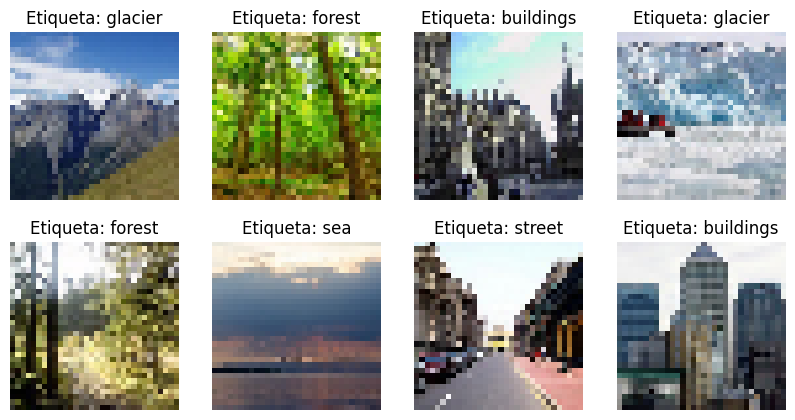

In [54]:
# Cargar los datos
X_train = np.load('cnn_train_X.npy', allow_pickle=True)
y_train = np.load('cnn_train_y.npy', allow_pickle=True)
X_test = np.load('cnn_test_X.npy', allow_pickle=True)
y_test = np.load('cnn_test_y.npy', allow_pickle=True)
X_pred = np.load('cnn_pred_X.npy', allow_pickle=True)

# Mostrar la cantidad de registros por categoría
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Distribución de clases en el conjunto de entrenamiento:", class_distribution)

# Visualizar algunas imágenes aleatorias
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    ax = axes[i // 4, i % 4]
    idx = random.randint(0, len(X_train) - 1)  
    ax.imshow(X_train[idx])
    ax.set_title(f"Etiqueta: {y_train[idx]}")
    ax.axis("off")
plt.show()



In [55]:
# Codificar las etiquetas con OneHotEncoder
encoder = OneHotEncoder(sparse_output=False) 
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

2. Implementa una red neuronal multicapa Fully Connected para clasificar las
imágenes, las que deben contener un mínimo de cinco capas ocultas. Despliega las
métricas (aplicadas al conjunto de test) que estimes conveniente para medir el
rendimiento del modelo.


In [56]:
print(y_train_encoded.dtype,y_test_encoded.dtype)  # Verifica el tipo de datos de y_train
#print(y_test_encoded.dtype)   # Verifica el tipo de datos de y_test

float64
float64


In [57]:
print("Forma de y_train_encoded:", y_train_encoded.shape)
print("Forma de y_test_encoded:", y_test_encoded.shape)

Forma de y_train_encoded: (14034, 6)
Forma de y_test_encoded: (3000, 6)


In [59]:

# Definir el modelo con más capas ocultas
model_mlp = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    layers.Flatten(),

    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    
    #layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
    #layers.Dropout(0.5), 
    
    layers.Dense(len(class_distribution), activation='softmax')
])
# Mostrar la estructura del modelo
model_mlp.summary()

# Compilar
model_mlp.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo
history = model_mlp.fit(
    X_train, y_train_encoded,
    epochs=20, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)                 │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,846,310 (14.67 MB)

 Trainable params: 3,846,310 (14.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1838 - loss: 19.2799 - val_accuracy: 0.0000e+00 - val_loss: 6.8420
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.2219 - loss: 5.4092 - val_accuracy: 0.0000e+00 - val_loss: 4.6624
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.3071 - loss: 3.0514 - val_accuracy: 0.0000e+00 - val_loss: 4.4060
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.3424 - loss: 2.1117 - val_accuracy: 0.0000e+00 - val_loss: 4.7910
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3584 - loss: 1.7289 - val_accuracy: 0.0000e+00 - val_loss: 4.5141
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3633 - loss: 1.5644 - val_accuracy: 0.0000e+00 - val_loss: 5.2635
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.3838 - loss: 1.4907 - val_accuracy: 0.0000e+00 - val_loss: 6.4209
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accur

In [61]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_mlp.evaluate(X_test, y_test_encoded, verbose=0)
print(f"\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")


Precisión en el conjunto de prueba: 0.3467
Pérdida en el conjunto de prueba: 2.6628


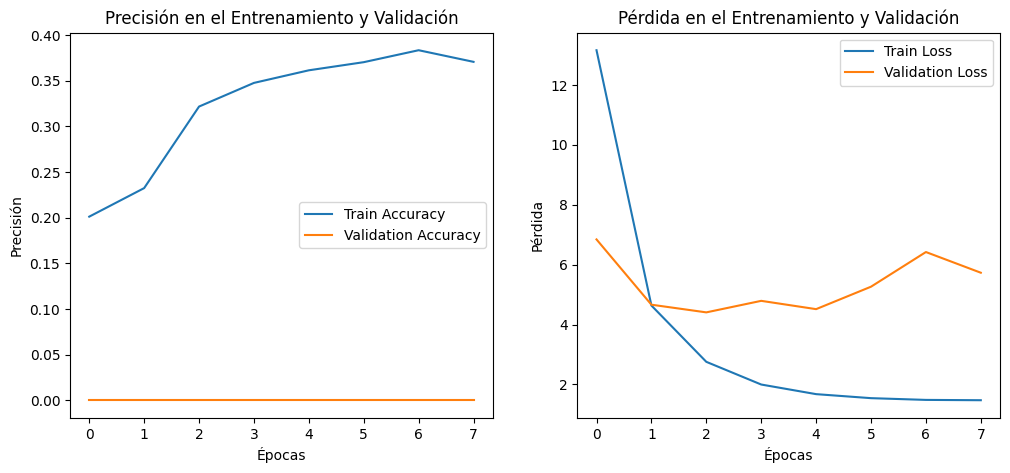

In [62]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión en el Entrenamiento y Validación')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida en el Entrenamiento y Validación')
plt.legend()

plt.show()

3. Desarrolla una red neuronal Convolucional usando tres o más capas convolucionales
y dos o más capas densas, de manera que la cantidad de parámetros a estimar se
encuentre en el intervalo [3MM, 8MM], con 25 épocas. Muestra la curva de la pérdida
para cada época y la curva de la métrica accuracy (conjunto test).


In [65]:

# Definir la red neuronal convolucional (CNN)
model_cnn = models.Sequential([
    
    layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(len(class_distribution), activation='softmax')
])

# Mostrar la estructura del modelo CNN
model_cnn.summary()

# Compilar la CNN con sparse_categorical_crossentropy
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenar la CNN
history_ = model_cnn.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar la CNN
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test_encoded)
print(f'Pérdida en el conjunto de test (CNN): {test_loss_cnn}, Precisión (CNN): {test_accuracy_cnn}')


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)                  │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,471,558 (9.43 MB)

 Trainable params: 2,471,558 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.5747 - loss: 1.0531 - val_accuracy: 0.1236 - val_loss: 9.0810
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7566 - loss: 0.6525 - val_accuracy: 0.1350 - val_loss: 11.9682
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8002 - loss: 0.5394 - val_accuracy: 0.1600 - val_loss: 11.0254
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8230 - loss: 0.4871 - val_accuracy: 0.1468 - val_loss: 10.7276
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8371 - loss: 0.4366 - val_accuracy: 0.1550 - val_loss: 11.5982
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8642 - loss: 0.3727 - val_accuracy: 0.1592 - val_loss: 12.6715
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8833 - loss: 0.3321 - val_accuracy: 0.1525 - val_loss: 11.5076
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9040 - loss: 0.2

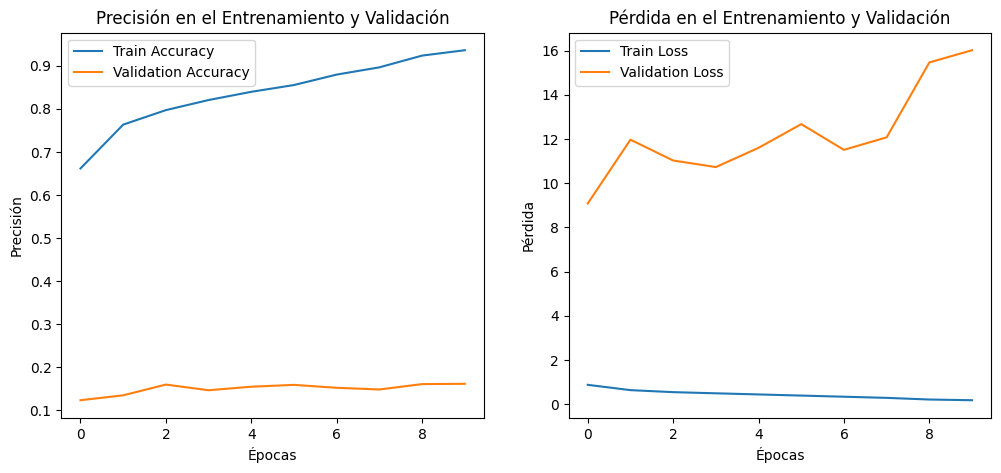

In [66]:
# Graficar la curva de pérdida y accuracy
plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history_.history['accuracy'], label='Train Accuracy')
plt.plot(history_.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión en el Entrenamiento y Validación')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history_.history['loss'], label='Train Loss')
plt.plot(history_.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida en el Entrenamiento y Validación')
plt.legend()

plt.show()

__________________________________________________________________________________________________________________________________

La precisión en el conjunto de entrenamiento aumenta constantemente, alcanzando valores muy altos (por ejemplo, 98.67% al final del entrenamiento).

Esto indica que el modelo está aprendiendo muy bien los datos de entrenamiento, pero no está generalizando a datos no vistos.

Precisión en la Validación:
La precisión en el conjunto de validación se mantiene muy baja (alrededor de 14-16%) y no mejora significativamente a lo largo de las épocas.

Esto sugiere que el modelo no está generalizando bien a los datos de validación.

Pérdida en el Entrenamiento vs. Validación:
La pérdida en el entrenamiento disminuye de manera constante, mientras que la pérdida en la validación aumenta o se mantiene en valores altos.

Esto es un indicador claro de sobreajuste.

Resultados en el Conjunto de Prueba:
La precisión en el conjunto de prueba es del 66.07%, lo cual es mejor que la precisión en la validación, pero aún indica que el modelo no está generalizando de manera óptima.

4. Implementa una red neuronal Convolucional que mejore la capacidad de
generalización alcanzada en el modelo anterior. Para esto usa 16 o más capas (entre
convolucionales y densas) y mide su rendimiento.

In [74]:

# Definir la red neuronal convolucional (CNN) con más de 16 capas
model_cnn_1 = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    
    # Primer bloque convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),#Se han agregado capas de Batch Normalization después de cada capa convolucional para  ajustar el modelo
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Segundo bloque convolucional
    layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Tercer bloque convolucional
    layers.Conv2D(256, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Cuarto bloque convolucional
    layers.Conv2D(512, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Aplanar y capas densas
    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_distribution), activation='softmax') 
])

# Mostrar la estructura del modelo CNN
model_cnn_1.summary()

# Compilar la CNN
model_cnn_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ImageDataGenerator para la aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustar el modelo
history = model_cnn_1.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping]
)
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_cnn_1.evaluate(X_test, y_test_encoded)
print(f'Pérdida en el conjunto de test (CNN): {test_loss}, Precisión (CNN): {test_accuracy}')

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_147 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_148 (Conv2D)                  │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_149 (Conv2D)                  │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_150 (Conv2D)                  │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_151 (Conv2D)                  │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_152 (Conv2D)                  │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_78 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_153 (Conv2D)                  │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_154 (Conv2D)                  │ (None, 4, 4, 512)           │       2,359,8

 Total params: 7,481,030 (28.54 MB)

 Trainable params: 7,477,190 (28.52 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/10


C:\Users\56939\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 168s 369ms/step - accuracy: 0.4081 - loss: 28.7948 - val_accuracy: 0.4070 - val_loss: 21.2332
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 158s 360ms/step - accuracy: 0.6135 - loss: 18.7897 - val_accuracy: 0.7203 - val_loss: 13.3723
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 158s 361ms/step - accuracy: 0.6831 - loss: 12.1887 - val_accuracy: 0.7427 - val_loss: 8.7201
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 158s 360ms/step - accuracy: 0.7044 - loss: 8.0584 - val_accuracy: 0.7667 - val_loss: 5.8830
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 160s 365ms/step - accuracy: 0.7241 - loss: 5.5032 - val_accuracy: 0.7807 - val_loss: 4.1088
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 160s 364ms/step - accuracy: 0.7390 - loss: 3.9059 - val_accuracy: 0.7750 - val_loss: 3.0311
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 161s 367ms/step - accuracy: 0.7516 - loss: 2.9086 - val_accuracy: 0.7623 - val_loss: 2.3822
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 162s 369ms/step - accuracy: 0.7632 - loss:

In [75]:
# Identificar la etiqueta con más errores
y_test_labels = np.argmax(y_test_encoded, axis=1)  # Si y_test_encoded está en one-hot
predictions = np.argmax(model_cnn.predict(X_test), axis=1)
errors = y_test_labels != predictions

if np.any(errors):  # Verifica si hay errores
    misclassified_labels, misclassified_counts = np.unique(y_test_labels[errors], return_counts=True)
    most_misclassified = misclassified_labels[np.argmax(misclassified_counts)]
    print(f'Etiqueta con más errores: {most_misclassified}')
else:
    print('No se encontraron errores en las predicciones.')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Etiqueta con más errores: 4


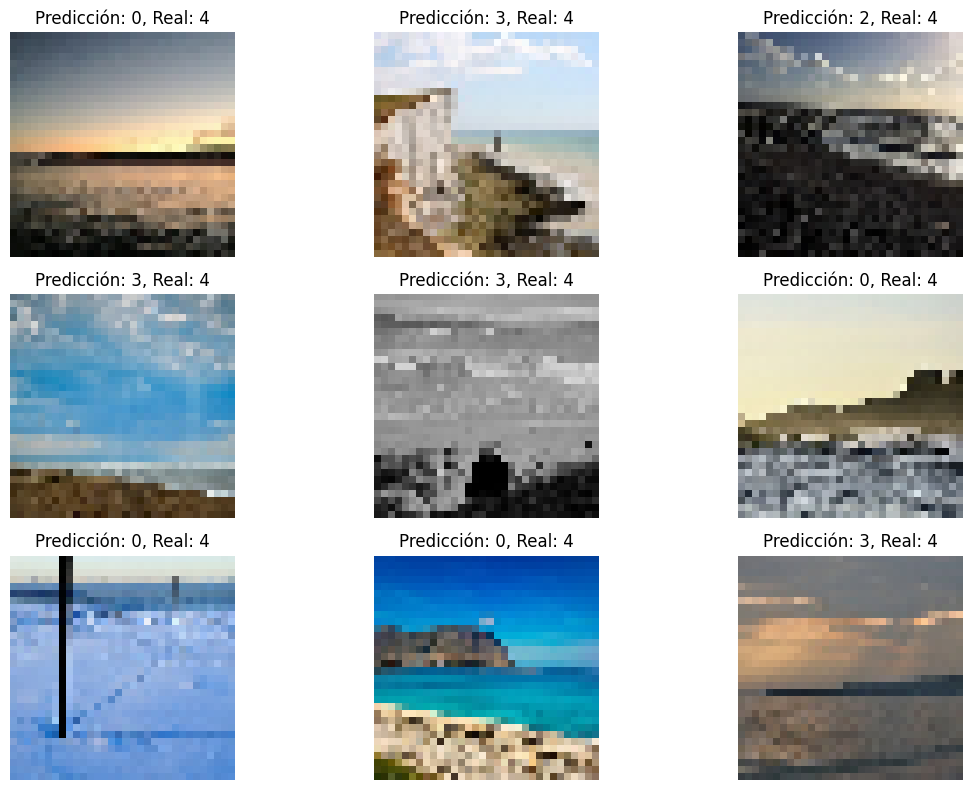

In [79]:
import matplotlib.pyplot as plt

# Obtener los índices de las imágenes clasificadas incorrectamente
misclassified_indices = np.where(errors)[0]
misclassified_images = X_test[misclassified_indices]
misclassified_labels = y_test_labels[errors]

# Filtrar las imágenes que pertenecen a la clase 4
class_4_errors = misclassified_indices[misclassified_labels == 4]

# Visualizar algunas de las imágenes clasificadas incorrectamente
plt.figure(figsize=(12, 8))
for i, idx in enumerate(class_4_errors[:9]):  # Mostrar las primeras 9 imágenes
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])  # Usar X_test directamente
    plt.title(f'Predicción: {predictions[idx]}, Real: {y_test_labels[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()